In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score
import warnings

import matplotlib.pyplot as plt
%matplotlib inline

# Анализ поступательной способности студентов при помощи логистической регрессии и RandomForest

##### Дополнительный проект, автор - Халенёва Дарья

In [2]:
warnings.filterwarnings('ignore')

### EDA данных

In [3]:
data = pd.read_csv('binary.csv')
data

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4
...,...,...,...,...
395,0,620,4.00,2
396,0,560,3.04,3
397,0,460,2.63,2
398,0,700,3.65,2


In [4]:
# Проверим на отсутствующие значения

data.isnull().sum()

admit    0
gre      0
gpa      0
rank     0
dtype: int64

In [5]:
# Проверим сбалансированность классов

print(data['admit'].value_counts(normalize=True).to_string())

0    0.6825
1    0.3175


#### Присутствует небольшой дисбаланс классов, поэтому в качестве основной метрики будем использовать взвешенный F1

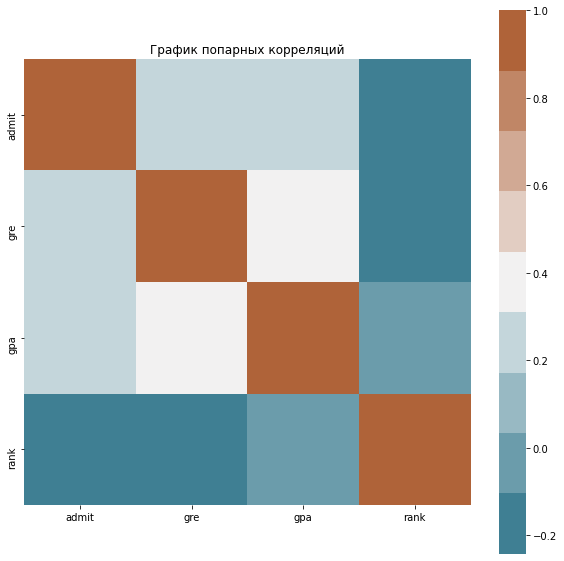

In [6]:
# График попарных корреляций

fig, ax =plt.subplots(figsize=(10, 10))
plt.title("График попарных корреляций")
sns.heatmap(data.corr(), mask=np.zeros_like(data.corr(), dtype=bool), cmap=sns.diverging_palette(220, 30, n=9),
            square=True, ax=ax)
plt.show()

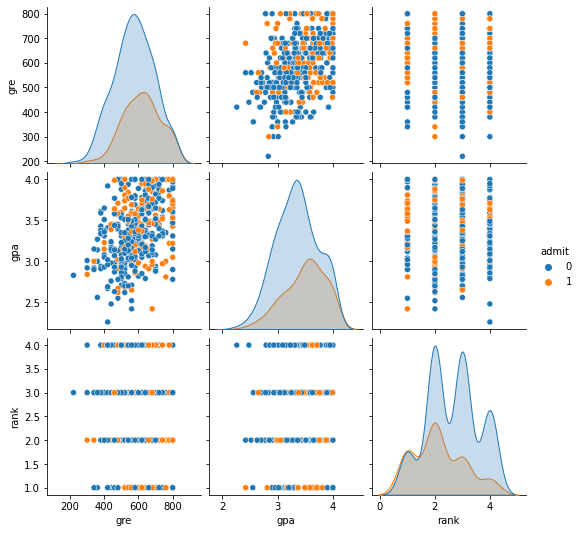

In [7]:
# Распределение данных в зависимости от целевой переменной
sns.pairplot(data, hue='admit')
plt.show()

### Закодируем дискретную переменную rank по принципу one-hot encoding

In [8]:
rank_one_hot = pd.get_dummies(data['rank'], prefix='rank')
data_one_hot = pd.concat([data, rank_one_hot], axis=1)
data_one_hot = data_one_hot.drop(columns='rank')
data_one_hot

,admit,gre,gpa,rank_1,rank_2,rank_3,rank_4
0,0,380,3.61,0,0,1,0
1,1,660,3.67,0,0,1,0
2,1,800,4.00,1,0,0,0
3,1,640,3.19,0,0,0,1
4,0,520,2.93,0,0,0,1
...,...,...,...,...,...,...,...
395,0,620,4.00,0,1,0,0
396,0,560,3.04,0,0,1,0
397,0,460,2.63,0,1,0,0
398,0,700,3.65,0,1,0,0


## Предсказание при помощи логистической регрессии

### Найдем лучшую модель семейства LogisticRegression с помощью grid search

In [9]:
X, y = np.array(data_one_hot[data_one_hot.columns[1:]]), np.array(data_one_hot['admit'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100500, stratify=y)

model = LogisticRegression()

# Пространство для поиска лучшего набора параметров
param_grid = {'penalty': ['l1', 'l2', 'elasticnet', 'none'],
              'C': [0.01, 0.05, 0.1, 0.3, 0.7, 1],
              'class_weight': ['balanced', None],
              'max_iter': [500]
             }

grid_clf = GridSearchCV(model,
                        param_grid,
                        cv=5,
                        scoring='f1_weighted',
                        n_jobs=10)

grid_clf.fit(X_train, y_train)


print(f'Лучший набор параметров: {grid_clf.best_params_}')
print(f'Лучшее значение метрики: {grid_clf.best_score_}')


Лучший набор параметров: {'C': 0.05, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l2'}
Лучшее значение метрики: 0.6295032269406515


### Обучим финальную модель лог. регрессии и оценим точность на тестовой выборке

In [10]:
linear_model = LogisticRegression(**grid_clf.best_params_)

linear_model.fit(X_train, y_train)

y_pred = linear_model.predict(X_test)

print('Итоговые метрики на тестовом множестве:\n')
print(classification_report(y_test, y_pred))

Итоговые метрики на тестовом множестве:

              precision    recall  f1-score   support

           0       0.75      0.63      0.69        68
           1       0.42      0.56      0.48        32

    accuracy                           0.61       100
   macro avg       0.59      0.60      0.58       100
weighted avg       0.65      0.61      0.62       100



### Визуализируем предсказания

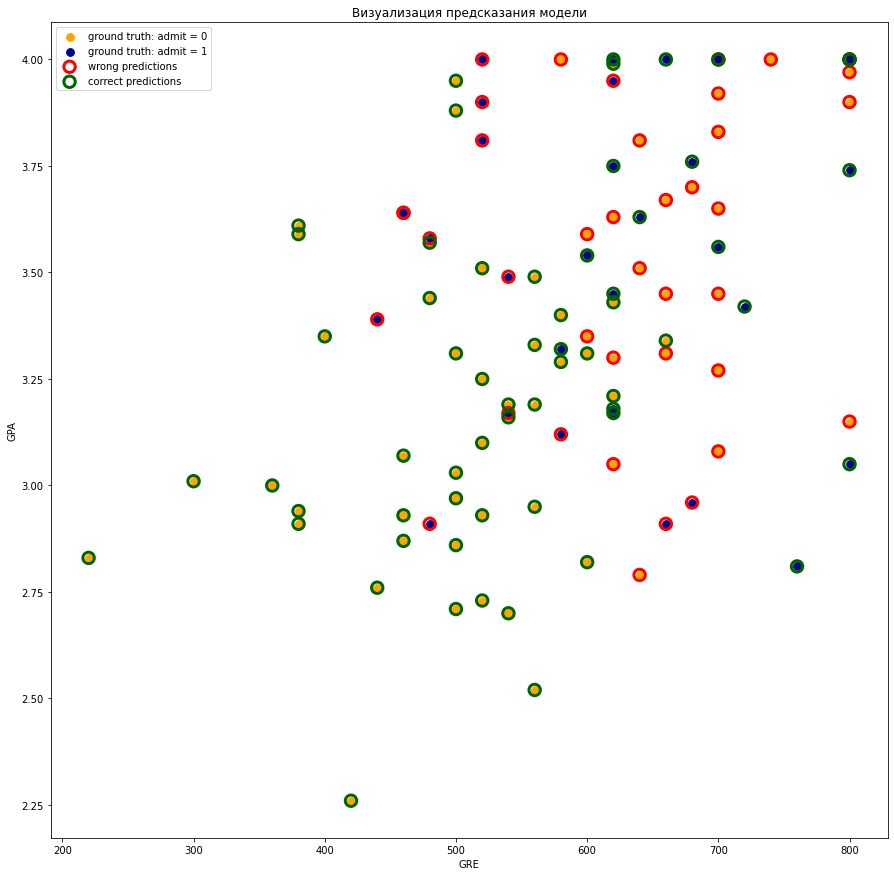

In [11]:
plt.figure(figsize=(15, 15))
plt.title('Визуализация предсказания модели')

plt.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], c='orange', label='ground truth: admit = 0', s=60)
plt.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], c='darkblue', label='ground truth: admit = 1', s=60)
correct_inds = np.argwhere(y_test == y_pred).ravel()
wrong_inds = np.argwhere(y_test != y_pred).ravel()

plt.scatter(X_test[wrong_inds, 0], X_test[wrong_inds, 1], facecolors='none', edgecolors='red', linewidth=3, s=130, label='wrong predictions')
plt.scatter(X_test[correct_inds, 0], X_test[correct_inds, 1], facecolors='none', edgecolors='darkgreen', s=130, linewidth=3, label='correct predictions')

plt.xlabel('GRE')
plt.ylabel('GPA')
plt.legend()
plt.show()

## Все то же самое для Random Forest

### Найдем лучшую модель семейства Random Forest с помощью grid search

In [12]:
X, y = np.array(data[['gre', 'gpa', 'rank']]), np.array(data['admit'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100500, stratify=y)

model = RandomForestClassifier()

# Пространство для поиска лучшего набора параметров
param_grid = {'n_estimators': list(range(300, 600, 50)),
              'max_depth': list(range(2, 10)),
              'max_features': ['sqrt', 'auto'],
              'criterion' : ['gini', 'entropy']
             }

grid_clf = GridSearchCV(model,
                        param_grid,
                        cv=5,
                        scoring='f1_weighted',
                        n_jobs=10)

grid_clf.fit(X_train, y_train)


print(f'Лучший набор параметров: {grid_clf.best_params_}')
print(f'Лучшее значение метрики: {grid_clf.best_score_}')

Лучший набор параметров: {'criterion': 'entropy', 'max_depth': 9, 'max_features': 'sqrt', 'n_estimators': 300}
Лучшее значение метрики: 0.6565467924187448


### Обучим финальную модель и оценим точность на тестовой выборке

In [13]:
rf_model = RandomForestClassifier(**grid_clf.best_params_)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

print('Итоговые метрики на тестовом множестве:\n')
print(classification_report(y_test, y_pred))

Итоговые метрики на тестовом множестве:

              precision    recall  f1-score   support

           0       0.74      0.94      0.83        68
           1       0.69      0.28      0.40        32

    accuracy                           0.73       100
   macro avg       0.71      0.61      0.61       100
weighted avg       0.72      0.73      0.69       100



#### Точность модели Random Forest получается примерно на 10% выше, чем у лог. регрессии!

In [14]:
# Оценим точность модели для разных rank

for rank in range(1, 5):
    inds = np.argwhere(X_test[:, 2] == rank).ravel()
    X_rank = X_test[inds]
    y_rank = y_test[inds]
    y_rank_pred = rf_model.predict(X_rank)
    
    print(f'F1 score for rank={rank}:  {f1_score(y_rank, y_rank_pred, average="weighted")}')

F1 score for rank=1:  0.5584747733085329
F1 score for rank=2:  0.6666666666666666
F1 score for rank=3:  0.635016835016835
F1 score for rank=4:  1.0


#### Для учебных заведений с престижностью (rank) = 4 модель не совершает ошибок!

## Оценим относительную важность признаков

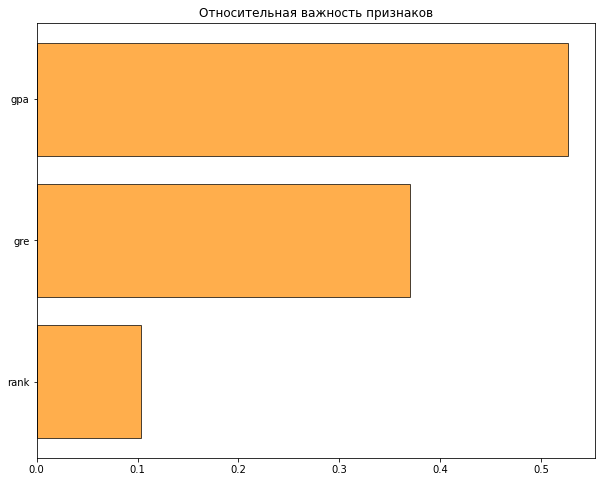

In [21]:
features = ['gre', 'gpa', 'rank']
importances = rf_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 8))
plt.title('Относительная важность признаков')
plt.barh(range(len(indices)), importances[indices], color='darkorange', align='center',alpha=0.7, edgecolor='black')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.show()

## Визуализируем предсказания

Используем первые 2 значимых признака: GPA и GRE

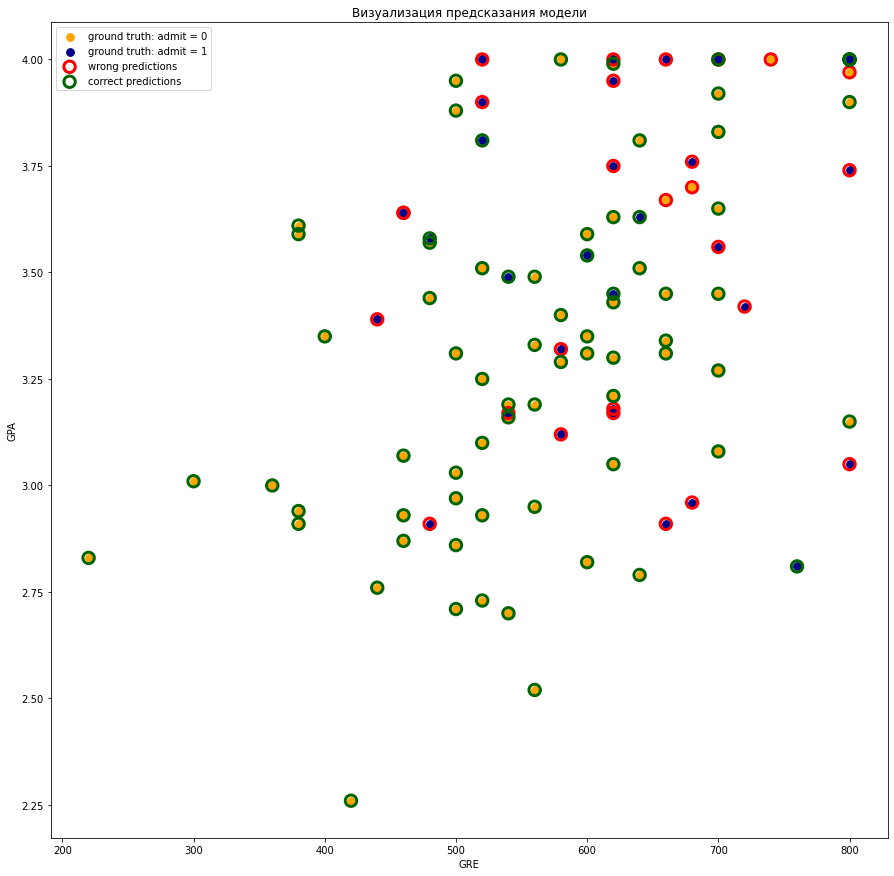

In [16]:
plt.figure(figsize=(15, 15))
plt.title('Визуализация предсказания модели')

plt.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], c='orange', label='ground truth: admit = 0', s=60)
plt.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], c='darkblue', label='ground truth: admit = 1', s=60)
correct_inds = np.argwhere(y_test == y_pred).ravel()
wrong_inds = np.argwhere(y_test != y_pred).ravel()

plt.scatter(X_test[wrong_inds, 0], X_test[wrong_inds, 1], facecolors='none', edgecolors='red', linewidth=3, s=130, label='wrong predictions')
plt.scatter(X_test[correct_inds, 0], X_test[correct_inds, 1], facecolors='none', edgecolors='darkgreen', s=130, linewidth=3, label='correct predictions')

plt.xlabel('GRE')
plt.ylabel('GPA')
plt.legend()
plt.show()

## Визуализируем предсказания с использованием всех исходных признаков

Предварительно понизив размерность данных с помощью PCA и t-SNE

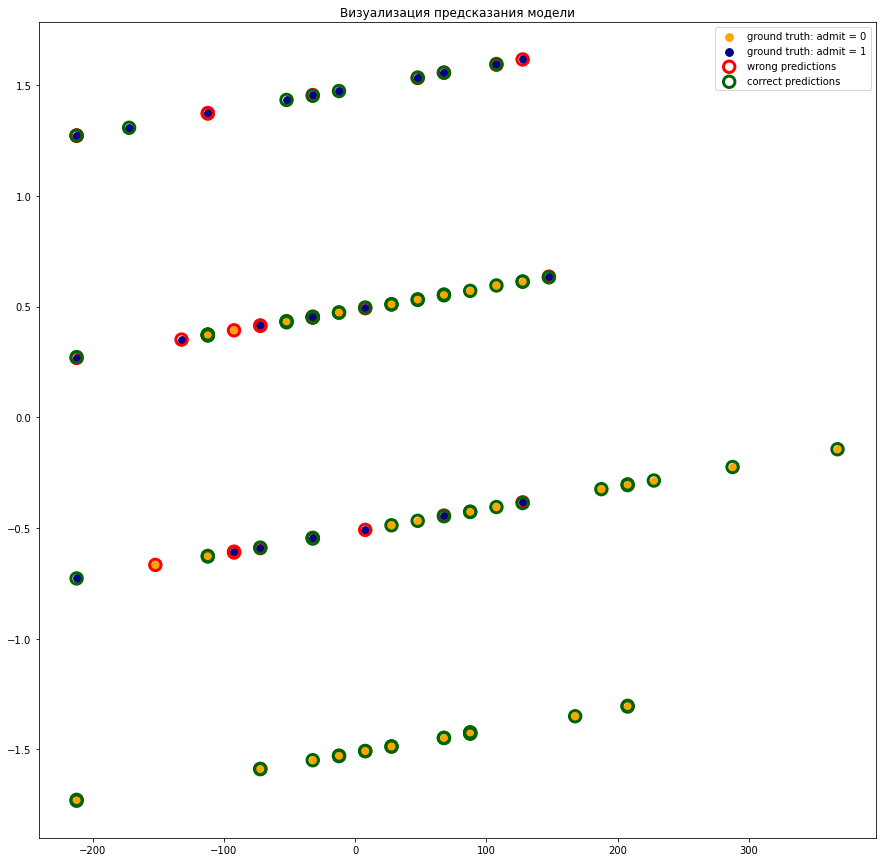

In [17]:
# Визуализация посредством PCA

pca = PCA(n_components=2)
pca.fit(X)

X_test_2d = pca.transform(X_test)

plt.figure(figsize=(15, 15))
plt.title('Визуализация предсказания модели')

plt.scatter(X_test_2d[y_test == 0, 0], X_test_2d[y_test == 0, 1], c='orange', label='ground truth: admit = 0', s=60)
plt.scatter(X_test_2d[y_test == 1, 0], X_test_2d[y_test == 1, 1], c='darkblue', label='ground truth: admit = 1', s=60)
correct_inds = np.argwhere(y_test == y_pred).ravel()
wrong_inds = np.argwhere(y_test != y_pred).ravel()

plt.scatter(X_test_2d[wrong_inds, 0], X_test_2d[wrong_inds, 1], facecolors='none', edgecolors='red', linewidth=3, s=130, label='wrong predictions')
plt.scatter(X_test_2d[correct_inds, 0], X_test_2d[correct_inds, 1], facecolors='none', edgecolors='darkgreen', s=130, linewidth=3, label='correct predictions')

plt.legend()
plt.show()

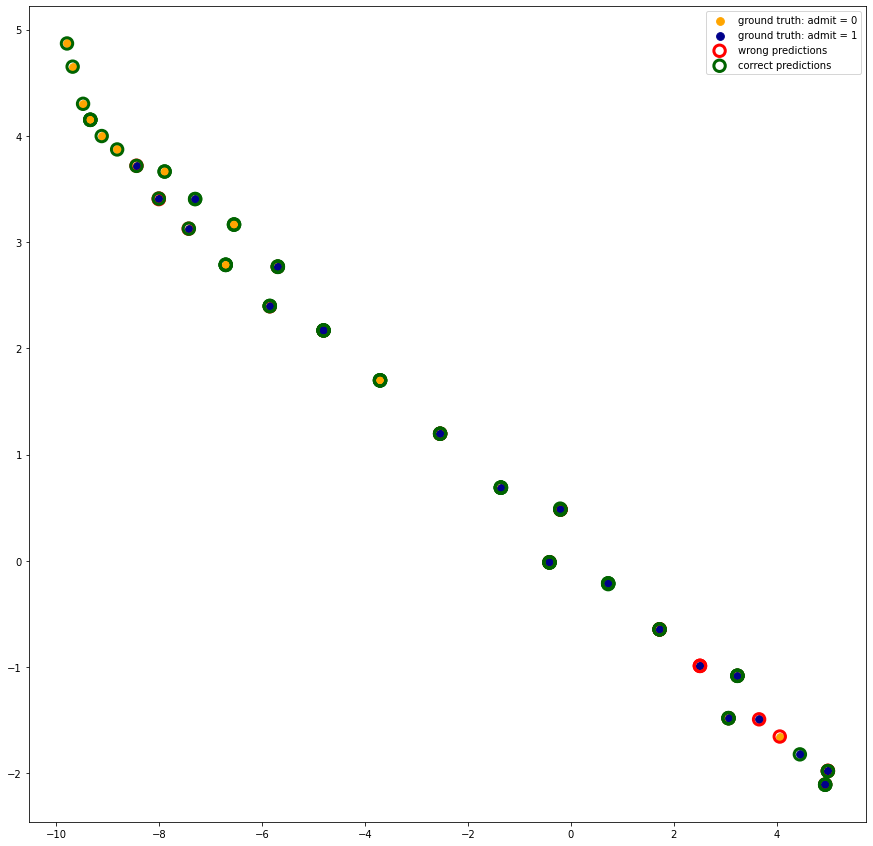

In [18]:
# Визуализация посредством t-SNE

X_test_2d_tsne = TSNE(n_components=2).fit_transform(X_test)

plt.figure(figsize=(15, 15))

plt.scatter(X_test_2d_tsne[y_test == 0, 0], X_test_2d_tsne[y_test == 0, 1], c='orange', label='ground truth: admit = 0', s=60)
plt.scatter(X_test_2d_tsne[y_test == 1, 0], X_test_2d_tsne[y_test == 1, 1], c='darkblue', label='ground truth: admit = 1', s=60)

plt.scatter(X_test_2d_tsne[wrong_inds, 0], X_test_2d_tsne[wrong_inds, 1], facecolors='none', edgecolors='red', s=130, linewidth=3, label='wrong predictions')
plt.scatter(X_test_2d_tsne[correct_inds, 0], X_test_2d_tsne[correct_inds, 1], facecolors='none', edgecolors='darkgreen', s=130, linewidth=3, label='correct predictions')
plt.legend()

plt.show()